In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
from typing import List
from urllib.parse import urlparse

import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine

In [4]:
import matplotlib.pyplot as plt

## Connect to database and query data

In [5]:
PROJECT_SRC = '/workspace/src'
os.chdir(PROJECT_SRC)
    
SQLALCHEMY_DATABASE_URI='sqlite:///../data/database.db'
engine = create_engine(SQLALCHEMY_DATABASE_URI, echo=False)

In [6]:
with engine.connect() as conn:
    
    join_txt='''
    SELECT 
        g.dttm, 
        wind, 
        solar, 
        load_mwh,
        price
    FROM GENERATION as g
    INNER JOIN
    LOAD as l
    ON g.dttm = l.dttm
    INNER JOIN
    PRICE as p
    ON g.dttm = p.dttm
    
    '''
    
    data = pd.read_sql(join_txt, engine)
    
data


,dttm,wind,solar,load_mwh,price
0,2020-01-01 01:00:00.000000,12443.0,0.0,16368.09,12.52
1,2020-01-01 02:00:00.000000,12338.8,0.0,15948.21,12.35
2,2020-01-01 03:00:00.000000,12075.4,0.0,15586.64,12.06
3,2020-01-01 04:00:00.000000,11957.9,0.0,15336.74,11.97
4,2020-01-01 05:00:00.000000,12012.6,0.0,15288.27,12.37
...,...,...,...,...,...
21331,2022-06-07 20:00:00.000000,2421.1,76.9,17522.10,89.35
21332,2022-06-07 21:00:00.000000,2375.1,5.3,17342.36,77.73
21333,2022-06-07 22:00:00.000000,2391.7,0.0,17100.03,70.13
21334,2022-06-07 23:00:00.000000,2348.4,0.0,16229.20,63.36


In [7]:
data.dttm = pd.to_datetime(data.dttm)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21336 entries, 0 to 21335
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      21336 non-null  datetime64[ns]
 1   wind      21335 non-null  float64       
 2   solar     21334 non-null  float64       
 3   load_mwh  21336 non-null  float64       
 4   price     21336 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 833.6 KB


In [9]:
# find any gaps in timeseries
all_hours = pd.DataFrame({'dttm':pd.date_range(data.dttm.min(), data.dttm.max(), freq='H')})
data = all_hours.merge(data, on='dttm', how='left')

In [ ]:
data.describe()

In [11]:
data.isna().sum()

dttm        0
wind        1
solar       2
load_mwh    0
price       0
dtype: int64

In [12]:
data.fillna(method='ffill', inplace=True)

In [13]:
data.isna().sum()

dttm        0
wind        0
solar       0
load_mwh    0
price       0
dtype: int64

In [14]:
data.set_index('dttm', inplace=True)

In [15]:
data

,wind,solar,load_mwh,price
dttm,,,,
2020-01-01 01:00:00,12443.0,0.0,16368.09,12.52
2020-01-01 02:00:00,12338.8,0.0,15948.21,12.35
2020-01-01 03:00:00,12075.4,0.0,15586.64,12.06
2020-01-01 04:00:00,11957.9,0.0,15336.74,11.97
2020-01-01 05:00:00,12012.6,0.0,15288.27,12.37
...,...,...,...,...
2022-06-07 20:00:00,2421.1,76.9,17522.10,89.35
2022-06-07 21:00:00,2375.1,5.3,17342.36,77.73
2022-06-07 22:00:00,2391.7,0.0,17100.03,70.13


<AxesSubplot:>

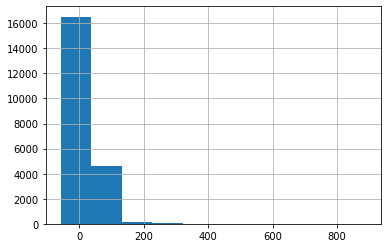

In [16]:
data.price.hist()

In [17]:
np.percentile(data.price, (0.5, 99.25))

array([ -6.056   , 140.319625])

In [18]:
MAX_PRICE = 175
data.loc[data.price > MAX_PRICE, 'price'] = MAX_PRICE

In [19]:
data.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,7461.330062,43.085527,16689.353952,28.596543
std,4110.794662,67.297909,2425.926154,22.838198
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7299.000000,0.500000,16506.295000,21.950000
75%,10985.025000,73.725000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,175.000000


## Data scaling

In [20]:
# define lookback and lookforward periods for 
# gathering training/test sets and creating
# t_idx: a data frame time indexes for the 
# lookback and lookforward periods
LOOKBACK = 23 
LOOKFORWARD = 24

In [21]:
# get training and test indexes
np.random.seed(42)
TRAIN_IDX = np.random.choice(range(data.shape[0]-LOOKBACK-LOOKFORWARD), size=int(0.8*len(data)), replace=False)
TRAIN_IDX

array([20662,  5921, 14187, ...,  1717,  2696,  1848])

In [22]:
TEST_IDX = np.setdiff1d(range(data.shape[0]-LOOKBACK-LOOKFORWARD),TRAIN_IDX)
TEST_IDX

array([    9,    11,    13, ..., 21281, 21286, 21288])

### Gather scaler metrics

In [23]:
scaler = {}
scaler['means'] = data.iloc[TRAIN_IDX,:].mean()
scaler['means']

wind         7459.590831
solar          42.801558
load_mwh    16695.477854
price          28.517849
dtype: float64

In [24]:
scaler['sd'] = data.iloc[TRAIN_IDX,:].std()
scaler['sd']

wind        4109.340388
solar         67.098413
load_mwh    2425.745195
price         22.721287
dtype: float64

In [25]:
scaler['min'] = data.iloc[TRAIN_IDX,:].min()
scaler['min']

wind           11.50
solar           0.00
load_mwh    10772.12
price         -45.87
dtype: float64

In [26]:
scaler['max'] = data.iloc[TRAIN_IDX,:].max()
scaler['max']

wind        17027.70
solar         403.00
load_mwh    25715.57
price         175.00
dtype: float64

### define scaling functions

In [27]:
def scale_data(data, scaler):
    return ((data - scaler['means'])/scaler['sd'])

data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,0.000423,0.004232,-0.002525,0.003463
std,1.000354,1.002973,1.000075,1.005145
min,-1.812478,-0.637892,-2.441871,-3.788423
25%,-0.867996,-0.637892,-0.727347,-0.547960
50%,-0.039079,-0.630441,-0.077990,-0.289061
75%,0.857908,0.460867,0.617347,0.280889
max,2.328381,5.405470,3.718483,6.446913


In [28]:
def unscale_data(data_scaled, scaler):
    return data_scaled*scaler['sd'] + scaler['means']

In [29]:
data = unscale_data(data_scaled, scaler)
data.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,7461.330062,43.085527,16689.353952,28.596543
std,4110.794662,67.297909,2425.926154,22.838198
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7299.000000,0.500000,16506.295000,21.950000
75%,10985.025000,73.725000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,175.000000


In [30]:
def scale_min_max(data, scaler):
    return ((data - scaler['min'])/(scaler['max']-scaler['min']))

In [31]:
data_scaled = scale_min_max(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,0.437808,0.106912,0.395975,0.337151
std,0.241581,0.166992,0.162340,0.103401
min,0.000000,0.000000,0.000000,-0.052927
25%,0.228089,0.000000,0.278316,0.280425
50%,0.428268,0.001241,0.383725,0.307058
75%,0.644887,0.182940,0.496598,0.365690
max,1.000000,1.006203,1.000000,1.000000


In [32]:
def unscale_min_max(data_scaled, scaler):
    return data_scaled*(scaler['max']-scaler['min']) + scaler['min']

In [33]:
data = unscale_min_max(data_scaled, scaler)
data.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,7461.330062,43.085527,16689.353952,28.596543
std,4110.794662,67.297909,2425.926154,22.838198
min,11.500000,0.000000,10772.120000,-57.560000
25%,3892.700000,0.000000,14931.120000,16.067500
50%,7299.000000,0.500000,16506.295000,21.950000
75%,10985.025000,73.725000,18193.005000,34.900000
max,17027.700000,405.500000,25715.570000,175.000000


### Create scaling data set for use in modeling

In [34]:
data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21336.000000,21336.000000,21336.000000,21336.000000
mean,0.000423,0.004232,-0.002525,0.003463
std,1.000354,1.002973,1.000075,1.005145
min,-1.812478,-0.637892,-2.441871,-3.788423
25%,-0.867996,-0.637892,-0.727347,-0.547960
50%,-0.039079,-0.630441,-0.077990,-0.289061
75%,0.857908,0.460867,0.617347,0.280889
max,2.328381,5.405470,3.718483,6.446913


## Create `t_idx` dataframe
`t_idx` has `t_start`, `t_now`, and `t_end` columns which define the start and end points of a sample based on the `LOOKBACK` and `LOOKFORWARD` windows.  This data frame is used in the data loader to produce samples.

In [35]:
def create_t_idx(
    data: pd.core.frame.DataFrame, 
    LOOKBACK: int, 
    LOOKFORWARD: int
) -> pd.core.frame.DataFrame:
    
    t_idx = pd.DataFrame()
    t_idx['t_start'] = data.index
    t_idx['t_now'] = data.index.shift(LOOKBACK, freq='H')
    t_idx['t_end'] = data.index.shift(LOOKBACK+LOOKFORWARD, freq='H')
    t_idx = t_idx[t_idx.t_end <= t_idx.t_start.max()]
    return t_idx

In [36]:
t_idx = create_t_idx(data, LOOKBACK, LOOKFORWARD)
t_idx

,t_start,t_now,t_end
0,2020-01-01 01:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00
1,2020-01-01 02:00:00,2020-01-02 01:00:00,2020-01-03 01:00:00
2,2020-01-01 03:00:00,2020-01-02 02:00:00,2020-01-03 02:00:00
3,2020-01-01 04:00:00,2020-01-02 03:00:00,2020-01-03 03:00:00
4,2020-01-01 05:00:00,2020-01-02 04:00:00,2020-01-03 04:00:00
...,...,...,...
21284,2022-06-05 21:00:00,2022-06-06 20:00:00,2022-06-07 20:00:00
21285,2022-06-05 22:00:00,2022-06-06 21:00:00,2022-06-07 21:00:00
21286,2022-06-05 23:00:00,2022-06-06 22:00:00,2022-06-07 22:00:00
21287,2022-06-06 00:00:00,2022-06-06 23:00:00,2022-06-07 23:00:00


## Test getting data from time indexes

In [37]:
# test_idx = 21118
test_idx = 0
t_idx.iloc[test_idx,:]

t_start   2020-01-01 01:00:00
t_now     2020-01-02 00:00:00
t_end     2020-01-03 00:00:00
Name: 0, dtype: datetime64[ns]

In [38]:
# get dataframe with historical and future timeseries values
# i.e. historical values from t_start:t_now and 
# future values from t_now:t_end
# in production future values would come from forecasts 
# but actuals will be used for training
hist_future_cols = ['wind', 'solar', 'load_mwh']
hist_future = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_end[test_idx], hist_future_cols]
hist_future

,wind,solar,load_mwh
dttm,,,
2020-01-01 01:00:00,1.212703,-0.637892,-0.134964
2020-01-01 02:00:00,1.187346,-0.637892,-0.308057
2020-01-01 03:00:00,1.123248,-0.637892,-0.457112
2020-01-01 04:00:00,1.094655,-0.637892,-0.560132
2020-01-01 05:00:00,1.107966,-0.637892,-0.580114
2020-01-01 06:00:00,1.102977,-0.637892,-0.552324
2020-01-01 07:00:00,1.034280,-0.637892,-0.458147
2020-01-01 08:00:00,0.906912,-0.637892,-0.384689
2020-01-01 09:00:00,0.770418,-0.637892,-0.275502


In [39]:
# get dataframe with historical timeseries values
label_cols = ['price']
hist = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_now[test_idx], label_cols]
hist

,price
dttm,
2020-01-01 01:00:00,-0.704091
2020-01-01 02:00:00,-0.711573
2020-01-01 03:00:00,-0.724336
2020-01-01 04:00:00,-0.728297
2020-01-01 05:00:00,-0.710693
2020-01-01 06:00:00,-0.609906
2020-01-01 07:00:00,-0.565454
2020-01-01 08:00:00,-0.618708
2020-01-01 09:00:00,-0.570736


In [40]:
# get dataframe with future timeseries label values
# this is what we're trying to predict
label_cols = ['price']
label = data_scaled.loc[(t_idx.t_now[test_idx]+pd.DateOffset(hours=1)):t_idx.t_end[test_idx], label_cols]
label

,price
dttm,
2020-01-02 01:00:00,-0.591421
2020-01-02 02:00:00,-0.656558
2020-01-02 03:00:00,-0.687366
2020-01-02 04:00:00,-0.722136
2020-01-02 05:00:00,-0.758225
2020-01-02 06:00:00,-0.725216
2020-01-02 07:00:00,-0.664920
2020-01-02 08:00:00,-0.712453
2020-01-02 09:00:00,-0.713773


In [41]:
# function to create tabular data from t_now index
# this will consist of one hot encoding for timestamp variables
def create_tabular_data(
    t_now: pd._libs.tslibs.timestamps.Timestamp
) -> pd.core.frame.DataFrame:
    
    hours = pd.DataFrame({f'hour_{i}':1*(t_now.hour == i) for i in range(24)}, index=[0])
    dayofweek = pd.DataFrame({f'dayofweek_{i}':1*(t_now.dayofweek == i) for i in range(7)}, index=[0])
    month = pd.DataFrame({f'month_{i}':1*(t_now.month == i) for i in range(1, 13)}, index=[0])
    # week = pd.DataFrame({f'week_{i}':1*(t_now.isocalendar()[1] == i) for i in range(1, 54)}, index=[0])
    day = pd.DataFrame({f'day_{i}':1*(t_now.day == i) for i in range(1,32)}, index=[0])
        
        
    return pd.concat([day, month, dayofweek, hours], axis=1)

In [42]:
tabular_data = create_tabular_data(t_idx.t_now[test_idx])
tabular_data.transpose()

,0
day_1,0
day_2,1
day_3,0
day_4,0
day_5,0
...,...
hour_19,0
hour_20,0
hour_21,0
hour_22,0


## Custom dataloader

In [43]:
# this the class for our custom data loader
# it will return our timeseries dataframes, tabular data, and target values
class CombineDataset(Dataset):

    def __init__(self, t_idx, data_scaled, hist_future_cols, label_cols):
        """
        Args:
            t_idx (pd.DataFrame): DataFrame with t_start, t_now, t_end columns
            t_idx (pd.DataFrame): DataFrame with wind, solar, load_mwh, price columns
            hist_future_cols (List[str]): List of column names with historical and future values
            label_cols (List[str]): List of label column names, used to create hist and label data
        Returns:
            hist_future (numpy.ndarray): sample with historical and future 
                wind, solar, load_mwh timeseries values
            hist (numpy.ndarray): sample with historical price time series values
            tabular (numpy.ndarray): sample with tabular data
            label (numpy.ndarray): sample with future prices that is used for the target variable
        """
        self.t_idx = t_idx
        self.data_scaled = data_scaled
        self.hist_future_cols = hist_future_cols
        self.label_cols = label_cols

    def __len__(self):
        return (self.t_idx.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # print(f'idx: {idx}')
        
        # get historical and future timeseries
        hist_future = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_end[idx], self.hist_future_cols
        ].transpose()

        # get historical label timeseries
        hist = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_now[idx], self.label_cols
        ].transpose()
       
        # get tabular data
        tabular = create_tabular_data(self.t_idx.t_now[idx])
        
        # get label timeseries
        label = self.data_scaled.loc[
            (self.t_idx.t_now[idx]+pd.DateOffset(hours=1)):self.t_idx.t_end[idx], self.label_cols
        ].transpose()

        return hist_future.values, hist.values, tabular.values, label.values

In [44]:
# create t_idx_train and t_idx_test for train and test dataloaders
t_idx_train = t_idx.iloc[TRAIN_IDX,:].reset_index(drop=True)
t_idx_train

,t_start,t_now,t_end
0,2022-05-10 23:00:00,2022-05-11 22:00:00,2022-05-12 22:00:00
1,2020-09-03 18:00:00,2020-09-04 17:00:00,2020-09-05 17:00:00
2,2021-08-14 04:00:00,2021-08-15 03:00:00,2021-08-16 03:00:00
3,2021-12-04 17:00:00,2021-12-05 16:00:00,2021-12-06 16:00:00
4,2020-12-04 10:00:00,2020-12-05 09:00:00,2020-12-06 09:00:00
...,...,...,...
17063,2020-04-26 03:00:00,2020-04-27 02:00:00,2020-04-28 02:00:00
17064,2021-01-20 20:00:00,2021-01-21 19:00:00,2021-01-22 19:00:00
17065,2020-03-12 14:00:00,2020-03-13 13:00:00,2020-03-14 13:00:00
17066,2020-04-22 09:00:00,2020-04-23 08:00:00,2020-04-24 08:00:00


In [45]:
t_idx_test = t_idx.iloc[TEST_IDX,:].reset_index(drop=True)
t_idx_test

,t_start,t_now,t_end
0,2020-01-01 10:00:00,2020-01-02 09:00:00,2020-01-03 09:00:00
1,2020-01-01 12:00:00,2020-01-02 11:00:00,2020-01-03 11:00:00
2,2020-01-01 14:00:00,2020-01-02 13:00:00,2020-01-03 13:00:00
3,2020-01-01 17:00:00,2020-01-02 16:00:00,2020-01-03 16:00:00
4,2020-01-02 01:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00
...,...,...,...
4216,2022-06-05 11:00:00,2022-06-06 10:00:00,2022-06-07 10:00:00
4217,2022-06-05 12:00:00,2022-06-06 11:00:00,2022-06-07 11:00:00
4218,2022-06-05 18:00:00,2022-06-06 17:00:00,2022-06-07 17:00:00
4219,2022-06-05 23:00:00,2022-06-06 22:00:00,2022-06-07 22:00:00


In [46]:
# build dataloader for testing dataloader functionality and examine outputs
loader_testing = DataLoader(
    CombineDataset(t_idx_train.loc[:64,:], data_scaled, hist_future_cols, label_cols),
    batch_size = 64,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

for data in loader_testing:
    hist_future, hist, tabular, label = data
    
    print(f'hist_future.shape: {hist_future.shape}')
    print(f'hist.shape: {hist.shape}')
    print(f'tabular.shape: {tabular.shape}')
    print(f'label.shape: {label.shape}')

hist_future.shape: torch.Size([64, 3, 48])
hist.shape: torch.Size([64, 1, 24])
tabular.shape: torch.Size([64, 1, 74])
label.shape: torch.Size([64, 1, 24])
hist_future.shape: torch.Size([1, 3, 48])
hist.shape: torch.Size([1, 1, 24])
tabular.shape: torch.Size([1, 1, 74])
label.shape: torch.Size([1, 1, 24])


In [47]:
# loader for training data
BATCH_SIZE_TRAIN = 512

train_set = CombineDataset(t_idx_train, data_scaled, hist_future_cols, label_cols)
loader_train = DataLoader(
    train_set,
    batch_size = BATCH_SIZE_TRAIN,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

In [48]:
# loader for testing data
BATCH_SIZE_TEST = 1024

test_set = CombineDataset(t_idx_test, data_scaled, hist_future_cols, label_cols)
loader_test = DataLoader(
    test_set,
    batch_size = BATCH_SIZE_TEST,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

## Build model

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
class Net(nn.Module):
    def __init__(self, 
                 hist_future_out_ch: List[int] = [8, 16],
                 hist_future_ks: List[int] = [3, 3],
                 hist_out_ch: List[int] = [8, 16],
                 hist_ks: List[int] = [3, 3],
                 drop_out: float = 0.0,
                 n_fc: List[int] = [256, 64, 256],
                ):
        super(Net, self).__init__()
        
        self.hist_future_in_ch = 3
        self.hist_in_ch = 1
        self.tabular_in_ch = 74
        
        self.steps_hist_future = 48
        self.steps_hist = 24
        self.label_out_ch = 24
        
        self.hist_future_out_ch = hist_future_out_ch
        self.hist_future_ks = hist_future_ks
        
        self.hist_out_ch = hist_out_ch
        self.hist_ks = hist_ks
        
        self.drop_out = drop_out
        
        # calculate the number of inputs for the first fully connected layer
        self.fc_in_ch = (
            self.hist_future_out_ch[-1]*self.steps_hist_future + 
            self.hist_out_ch[-1]*self.steps_hist + 
            self.tabular_in_ch
        )
        self.n_fc = n_fc
        
        # check inputs
        # out channel lists and kernel size lists need to be the same length
        len_hf_oc = len(self.hist_future_out_ch)
        len_hf_ks = len(self.hist_future_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_future_out_ch) ({len_hf_oc}) != len(hist_future_ks) ({len_hf_ks})"
        
        len_h_oc = len(self.hist_out_ch)
        len_h_ks = len(self.hist_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_out_ch) ({len_h_oc}) != len(hist_ks) ({len_h_ks})"
        
        
        # create convolution blocks
        self.hist_future_conv = nn.ModuleList()
        in_ch = [self.hist_future_in_ch] + self.hist_future_out_ch
        for i in range(len(self.hist_future_out_ch)):
            self.hist_future_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_future_out_ch[i], 
                        self.hist_future_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_future_out_ch[i]),
                    nn.ReLU()
                )
            )
            
        self.hist_conv = nn.ModuleList()
        in_ch = [self.hist_in_ch] + self.hist_out_ch
        for i in range(len(self.hist_out_ch)):
            self.hist_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_out_ch[i], 
                        self.hist_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_out_ch[i]),
                    nn.ReLU()
                )
            )
        
        
        # fully connected layers
        self.fc = nn.ModuleList()
        in_ch = [self.fc_in_ch] + self.n_fc
        for i in range(len(self.n_fc)):
            self.fc.append(nn.Linear(in_ch[i], self.n_fc[i]))
            self.fc.append(nn.BatchNorm1d(self.n_fc[i]))
            self.fc.append(nn.Dropout(self.drop_out))
            self.fc.append(nn.ReLU())
                
        self.fc.append(nn.Linear(self.n_fc[-1], self.label_out_ch))
    
    
    def forward(self, hist_future, hist, tabular):
        
        # forward pass through conv blocks
        for layer in self.hist_future_conv:
            hist_future = layer(hist_future)
        
        for layer in self.hist_conv:
            hist = layer(hist)
        
        # flatten layers for concatenation
        hist_future = torch.flatten(hist_future, start_dim=1)    
        hist = torch.flatten(hist, start_dim=1)
        tabular = torch.flatten(tabular, start_dim=1)
        x = torch.cat((hist_future, hist, tabular), dim=1)
        
        # forward pass through fully connected layers
        for layer in self.fc:
            x = layer(x)

        return x

In [52]:
def train(model, device, loader_train, optimizer, scaler, epoch, loss_func=F.mse_loss):
    model.train()
    rmse_losses = []
    for batch_idx, (hist_future, hist, tabular, label) in enumerate(loader_train):
        hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
        
        label = torch.flatten(label, start_dim=1)
        
        optimizer.zero_grad()
        output = model.forward(hist_future, hist, tabular)
        loss = loss_func(output, label)
        # loss = F.l1_loss(output, label)
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % (2**3) == 0:
            
            label = label*scaler['sd'].price+scaler['means'].price
            output = output*scaler['sd'].price+scaler['means'].price
            mse_loss = F.mse_loss(output, label, reduction="sum").item()
            mae_loss = F.l1_loss(output, label, reduction="mean").item()
            
            count = np.prod(label.shape)
            
            rmse_loss = np.sqrt(mse_loss/count)
            mean_error = torch.sum(output-label)/count
            
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tRMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
                    epoch,
                    batch_idx * len(hist_future),
                    len(loader_train.dataset),
                    100.0 * batch_idx / len(loader_train),
                    rmse_loss,
                    mae_loss,
                    mean_error
                )
            )
            
        rmse_losses+=[rmse_loss]
        
    return {
        'epoch':epoch,
        'losses':rmse_losses
    }

In [53]:
# function to print test error metrics during training
def test(model, device, loader_test, scaler, epoch):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            # label = label*(scaler['max'].price-scaler['min'].price) + scaler['min'].price
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            # output = output*(scaler['max'].price-scaler['min'].price) + scaler['min'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
            # mse_loss += torch.sum((output-label)**2)  # sum up batch loss
            # mae_loss += torch.sum(torch.abs((output-label)))  # sum up batch loss
    
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = np.sqrt(mse_loss/n_pred/n_step)
    mae_loss = mae_loss/n_pred/n_step
    mean_error = mean_error/n_pred/n_step
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {
        'epoch':epoch,
        'rmse_loss':rmse_loss, 
        'mae_loss':mae_loss,
        'mean_error':mean_error
    }

In [54]:
param_log_model = {
    'hist_future_out_ch':[8, 16],
    'hist_future_ks': [3, 3],
    'hist_out_ch': [8, 16],
    'hist_ks': [3, 3],
    'drop_out': 0.0,
    'n_fc': [512, 128, 512],
}

param_log_opti = {
    'lr': 0.001,
    'gamma': 0.95,
    'epochs': 15,
}

In [55]:
model = Net(**param_log_model).double().to(device)

In [56]:
print(model)

Net(
  (hist_future_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (hist_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1226, out_features=512, bias=True)
    (1): BatchNorm1d(51

In [57]:
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'total number of parameters: {num_params:,}')

total number of parameters: 775,560


In [58]:
for name, module in model.named_modules():
     print(f'{name}, \t- {sum(param.numel() for param in module.parameters()):,}')

, 	- 775,560
hist_future_conv, 	- 528
hist_future_conv.0, 	- 96
hist_future_conv.0.0, 	- 80
hist_future_conv.0.1, 	- 16
hist_future_conv.0.2, 	- 0
hist_future_conv.1, 	- 432
hist_future_conv.1.0, 	- 400
hist_future_conv.1.1, 	- 32
hist_future_conv.1.2, 	- 0
hist_conv, 	- 480
hist_conv.0, 	- 48
hist_conv.0.0, 	- 32
hist_conv.0.1, 	- 16
hist_conv.0.2, 	- 0
hist_conv.1, 	- 432
hist_conv.1.0, 	- 400
hist_conv.1.1, 	- 32
hist_conv.1.2, 	- 0
fc, 	- 774,552
fc.0, 	- 628,224
fc.1, 	- 1,024
fc.2, 	- 0
fc.3, 	- 0
fc.4, 	- 65,664
fc.5, 	- 256
fc.6, 	- 0
fc.7, 	- 0
fc.8, 	- 66,048
fc.9, 	- 1,024
fc.10, 	- 0
fc.11, 	- 0
fc.12, 	- 12,312


In [59]:
# test optimizer scheduler
optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
for epoch in range(1, param_log_opti['epochs'] + 1):
    optimizer.step()
    scheduler.step()
    
scheduler.state_dict()

{'gamma': 0.95,
 'base_lrs': [0.001],
 'last_epoch': 15,
 '_step_count': 16,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.00046329123015975297]}

In [60]:
optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
train_losses = []
results = []

for epoch in range(1, param_log_opti['epochs'] + 1):
    train_losses += [train(model, device, loader_train, optimizer, scaler, epoch)]
    results += [test(model, device, loader_test, scaler, epoch)]
    scheduler.step()
    
print('TRAINING COMPLETE')
print('______________________________________________________')


Train Epoch: 1 [0/17068 (0%)]	RMSE loss: 23.8127, MAE loss: 16.8710, Mean error: 0.4665
Train Epoch: 1 [4096/17068 (24%)]	RMSE loss: 19.0550, MAE loss: 11.3925, Mean error: -0.7731
Train Epoch: 1 [8192/17068 (47%)]	RMSE loss: 16.5671, MAE loss: 9.6954, Mean error: 0.4260
Train Epoch: 1 [12288/17068 (71%)]	RMSE loss: 15.7715, MAE loss: 9.3444, Mean error: 1.4489
Train Epoch: 1 [16384/17068 (94%)]	RMSE loss: 16.5504, MAE loss: 9.6320, Mean error: -0.3808
______________________________________________________

Test set: RMSE loss: 16.2419, MAE loss: 8.9849, Mean error: -1.6264
______________________________________________________
Train Epoch: 2 [0/17068 (0%)]	RMSE loss: 16.0372, MAE loss: 9.1070, Mean error: -1.0450
Train Epoch: 2 [4096/17068 (24%)]	RMSE loss: 15.4015, MAE loss: 8.8775, Mean error: 0.8059
Train Epoch: 2 [8192/17068 (47%)]	RMSE loss: 14.6838, MAE loss: 8.5336, Mean error: 1.0441
Train Epoch: 2 [12288/17068 (71%)]	RMSE loss: 15.6551, MAE loss: 8.8872, Mean error: -0.3690
T

In [61]:
def test_post_train(model, device, loader_test, scaler):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            # label = label*(scaler['max'].price-scaler['min'].price) + scaler['min'].price
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            # output = output*(scaler['max'].price-scaler['min'].price) + scaler['min'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
            # mse_loss += torch.sum((output-label)**2)  # sum up batch loss
            # mae_loss += torch.sum(torch.abs((output-label)))  # sum up batch loss
    
    # scale historical prices
    hist = hist*scaler['sd'].price+scaler['means'].price
    # hist = hist*(scaler['max'].price-scaler['min'].price) + scaler['min'].price
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = np.sqrt(mse_loss/n_pred/n_step)
    mae_loss = mae_loss/n_pred/n_step
    mean_error = (mean_error/n_pred/n_step).item()
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {'test_rmse_loss':rmse_loss, 
            'test_mae_loss':mae_loss, 
            'test_mean_error':mean_error, 
            'label':label, 
            'hist_future':hist_future, 
            'hist':hist,
            'tabular':tabular,
            'output':output}

In [134]:
res = test_post_train(model, device, loader_test, scaler)

______________________________________________________

Test set: RMSE loss: 12.7137, MAE loss: 7.4502, Mean error: 0.4264
______________________________________________________


In [63]:
res['test_mean_error']

0.4263901845571322

In [64]:
error = (res['output'] - res['label']).cpu().numpy()
error.shape

(125, 24)

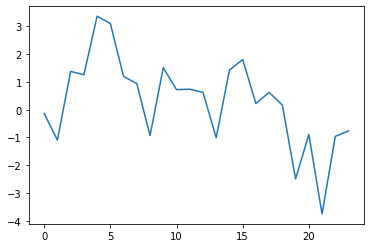

In [65]:
plt.plot(np.mean(error,axis=0));

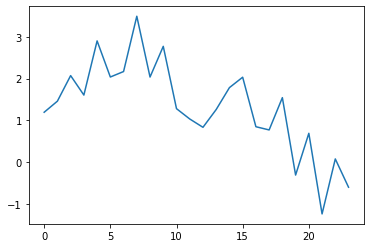

In [66]:
plt.plot(np.percentile(error, 50 ,axis=0));

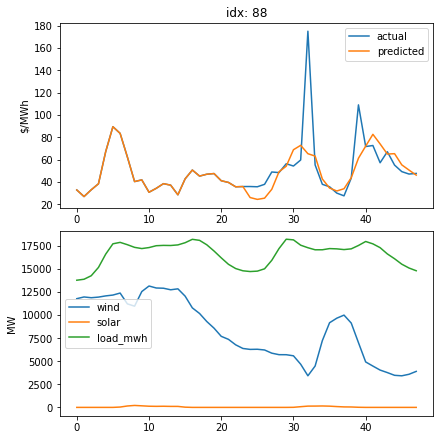

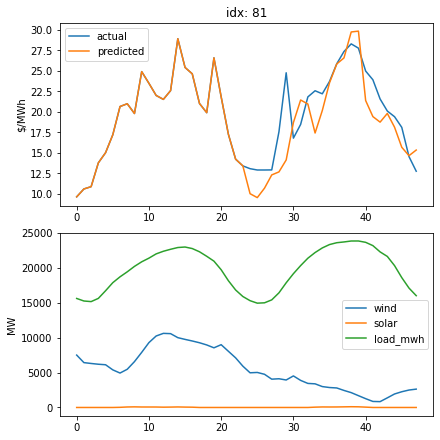

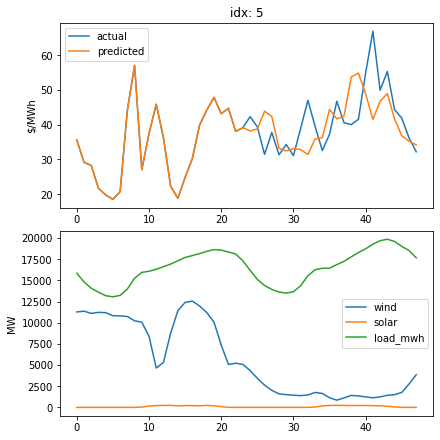

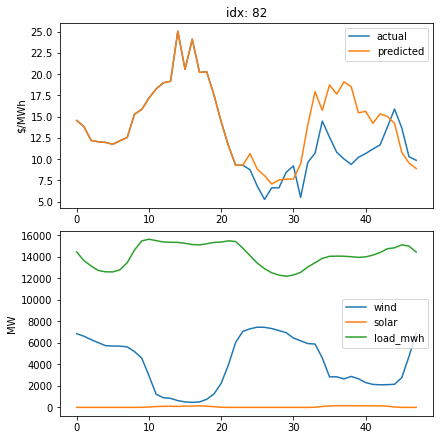

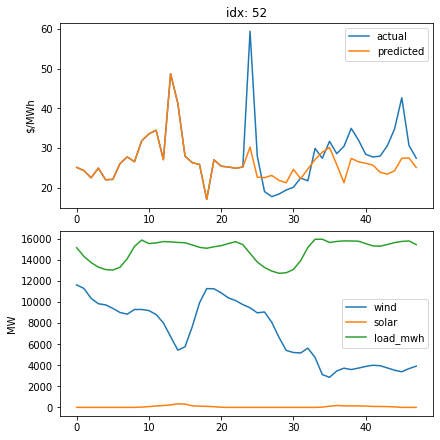

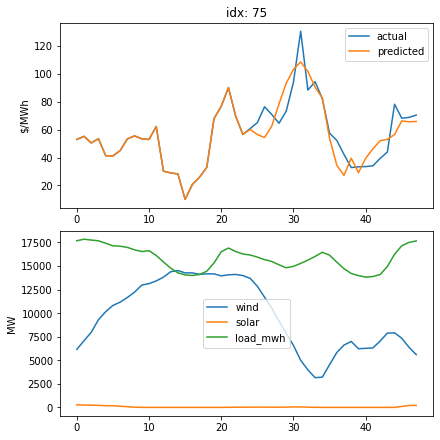

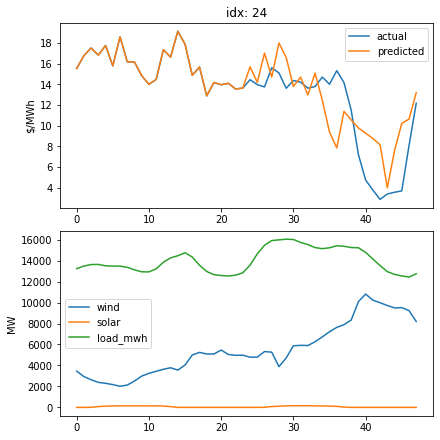

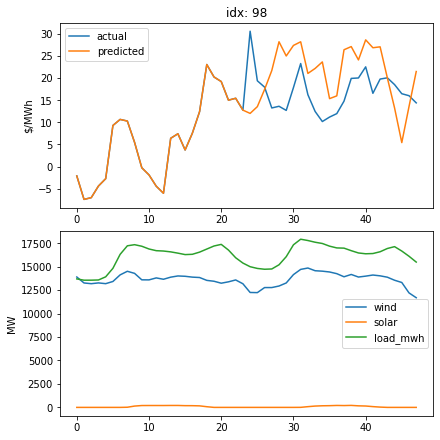

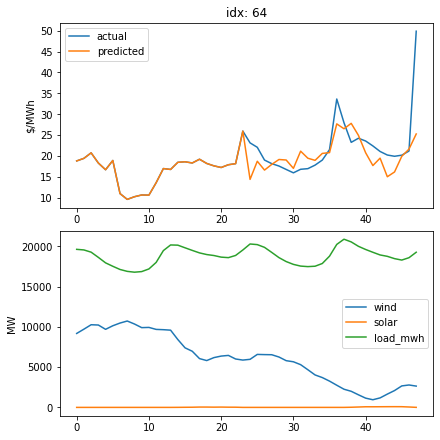

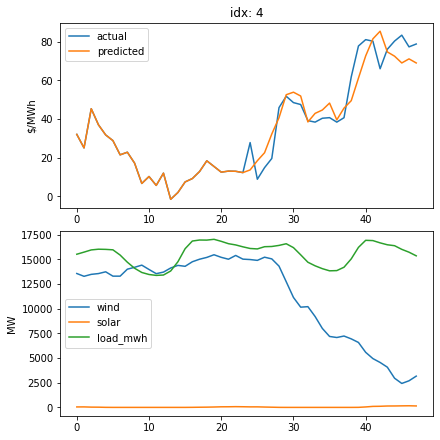

In [67]:
r_idx = np.random.randint(low=0, high=res['label'].shape[0], size=10, dtype=int)
for i in r_idx:
    
    hist_future_cols = ['wind', 'solar', 'load_mwh']
    hist_future = res['hist_future'][i,:].cpu().numpy()
    hist_future = np.transpose(hist_future)
    hist_future = (
        hist_future*scaler['sd'][hist_future_cols].values.reshape(1,-1)+
        scaler['means'][hist_future_cols].values.reshape(1,-1)
    )

    hist_future = pd.DataFrame(hist_future, columns=hist_future_cols)

    hist = res['hist'][i,:][0].cpu().numpy()
    
    actual = res['label'][i,:].cpu().numpy()
    actual = np.concatenate([hist, actual])

    predicted = res['output'][i,:].cpu().numpy()
    predicted = np.concatenate([hist, predicted])
    
    comp = pd.DataFrame(
        {'actual':actual, 'predicted':predicted}
    )
    
    fig, axs = plt.subplots(
        ncols=1, 
        nrows=2, 
        figsize=(6, 6),
        constrained_layout=True
    )
    
    comp.plot(ax=axs[0]);
    axs[0].set_ylabel('$/MWh')
    axs[0].set_title(f'idx: {i}');
    hist_future.plot(ax=axs[1]);
    axs[1].set_ylabel('MW')
    plt.show();
    print('=================================================================\n')


## MLFlow

In [68]:
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature

import warnings
warnings.filterwarnings("ignore")

In [69]:
# quiet warning when loggin run
!export GIT_PYTHON_REFRESH=quiet

In [70]:
# default: 'file:///{pwd}/mlruns'
mlflow.get_tracking_uri()

'file:///workspace/src/mlruns'

In [71]:
# MLFLOW_TRACKING_URI = 'sqlite:////workspace/mlruns/tracking.db'
MLFLOW_TRACKING_URI = 'file:///workspace/mlruns'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [72]:
# https://stackoverflow.com/questions/63255631/mlflow-invalid-parameter-value-unsupported-uri-mlruns-for-model-registry-s
# https://www.mlflow.org/docs/latest/tracking.html#scenario-3-mlflow-on-localhost-with-tracking-server
# mlflow.set_tracking_uri("http://localhost:5000")

In [73]:
# mlflow.set_tracking_uri('/workspace')
os.chdir('/workspace')

In [74]:
mlflow.get_tracking_uri()

'file:///workspace/mlruns'

In [75]:
# script model for logging
scripted_model = torch.jit.script(model)  

In [76]:
# parameters for logging
param_log = {'model':'pytorch_cnn'}
param_log.update(param_log_model)
param_log.update(param_log_opti)
param_log

{'model': 'pytorch_cnn',
 'hist_future_out_ch': [8, 16],
 'hist_future_ks': [3, 3],
 'hist_out_ch': [8, 16],
 'hist_ks': [3, 3],
 'drop_out': 0.0,
 'n_fc': [512, 128, 512],
 'lr': 0.001,
 'gamma': 0.95,
 'epochs': 15}

In [77]:
# metrics for logging
metrics = {}
for m in ['test_rmse_loss', 'test_mae_loss', 'test_mean_error']:
    metrics[m] = res[m]
metrics

{'test_rmse_loss': 12.71366646841578,
 'test_mae_loss': 7.450210695181661,
 'test_mean_error': 0.4263901845571322}

In [78]:
EXPERIMENT_NAME = "pytorch_cnn_miso_price"

In [79]:
# create experiment if it does not exist
exp_list = mlflow.list_experiments()
if not any([e.name == EXPERIMENT_NAME for e in exp_list]):
    mlflow.create_experiment(EXPERIMENT_NAME)

In [80]:
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment.experiment_id

'1'

In [81]:
# script model for logging
MODEL_URI = "/workspace/models/scripted_model.pt"
scripted_model = torch.jit.script(model) 
scripted_model.save(MODEL_URI)

In [82]:
MODEL_NAME = "pytorch_cnn"

In [83]:
with mlflow.start_run(experiment_id=experiment.experiment_id) as run:
    
    mlflow.log_params(param_log)
    mlflow.log_metrics(metrics)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.pytorch.log_model(
            pytorch_model=scripted_model,
            artifact_path=MODEL_NAME,
            registered_model_name="pytorch_cnn_price_reg"
        )
    else:
        mlflow.pytorch.log_model(
            pytorch_model=scripted_model, 
            artifact_path=MODEL_NAME)  # logging scripted model
    

2022/06/12 01:15:46 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



## MLFlow UI

To view logged models via the mlflow ui run: `mlflow ui` from the directory with the mlruns folder. In a terminal to start ui server and then go to: http://localhost:5000.

## MLFlow model serving

https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html#serving-the-model

in a terminal run:
`mlflow models serve -m /workspace/mlruns/1/<model_id>/artifacts/pytorch_cnn -p 1234`

for example there is currently a run with id: `cdb28e28248946728ace5c2024e47ff7`
so to serve this model run:
`mlflow models serve -m /workspace/mlruns/1/cdb28e28248946728ace5c2024e47ff7/artifacts/pytorch_cnn -p 1234`

after the container is build and ready it will output information on where it's listening in this case it's: http://127.0.0.1:1234 

In [84]:
import json
import requests

In [289]:
test_inference_data = {
    'hist_future':res['hist_future'][:1,:,:],
    'hist':res['hist'][:1,:,:],
    'tabular':res['tabular'][:1,:],
}
test_inference_data

{'hist_future': tensor([[[-7.3669e-01, -7.5893e-01, -7.6813e-01, -7.6353e-01, -7.1023e-01,
           -5.9369e-01, -5.3668e-01, -6.1693e-01, -8.9357e-01, -9.7429e-01,
           -9.4874e-01, -8.2758e-01, -6.7086e-01, -5.4120e-01, -4.5890e-01,
           -3.9858e-01, -3.2406e-01, -2.8087e-01, -2.7218e-01, -2.1967e-01,
           -3.8374e-02,  3.3979e-01,  5.6143e-01,  4.1844e-01,  5.4479e-01,
            5.1863e-01,  4.4501e-01,  4.6263e-01,  4.5226e-01,  4.6054e-01,
            3.5792e-01,  8.3325e-02, -2.9915e-01, -4.9796e-01, -6.6903e-01,
           -6.5424e-01, -4.5701e-01, -2.3636e-01, -5.8134e-02,  1.5331e-01,
            2.5009e-01,  2.2198e-01,  1.5677e-01,  4.8818e-02,  1.3411e-01,
            4.2134e-01,  4.9879e-01,  3.0380e-01],
          [-6.3789e-01, -6.3789e-01, -6.3789e-01, -6.3789e-01, -6.3789e-01,
           -6.3789e-01, -6.3789e-01, -6.3789e-01,  2.5185e-01,  3.0848e-01,
            2.6377e-01,  5.9314e-01,  8.9270e-01,  6.9895e-01,  6.9001e-01,
            8.8524e-01

In [290]:
test_inference_data['hist_future'].shape

torch.Size([1, 3, 48])

In [87]:
# ?infer_signature

In [88]:
# signature = infer_signature(test_inference_data, model(**test_inference_data))

In [291]:
model.to(device)
pred = model(**test_inference_data)
pred

tensor([[-3.0815, -2.6618, -1.8178, -1.5125, -1.3161, -0.8094, -0.6680, -0.8107,
         -0.8145,  0.4177,  0.7938,  0.4110, -0.1733,  0.3169,  0.6764,  3.0014,
          5.9084,  7.7556,  9.2990,  9.4952,  7.5741,  4.9338,  3.3517,  2.1533]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [292]:
scripted_model(**test_inference_data)

tensor([[-3.0815, -2.6618, -1.8178, -1.5125, -1.3161, -0.8094, -0.6680, -0.8107,
         -0.8145,  0.4177,  0.7938,  0.4110, -0.1733,  0.3169,  0.6764,  3.0014,
          5.9084,  7.7556,  9.2990,  9.4952,  7.5741,  4.9338,  3.3517,  2.1533]],
       device='cuda:0', dtype=torch.float64,
       grad_fn=<DifferentiableGraphBackward>)

In [293]:
pred.shape

torch.Size([1, 24])

In [92]:
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# https://www.tensorflow.org/tfx/serving/api_rest#request_format_2


# {
#  "instances": [
#    {
#      "tag": "foo",
#      "signal": [1, 2, 3, 4, 5],
#      "sensor": [[1, 2], [3, 4]]
#    },
#    {
#      "tag": "bar",
#      "signal": [3, 4, 1, 2, 5],
#      "sensor": [[4, 5], [6, 8]]
#    }
#  ]
# }

# {
#  "inputs": {
#    "tag": ["foo", "bar"],
#    "signal": [[1, 2, 3, 4, 5], [3, 4, 1, 2, 5]],
#    "sensor": [[[1, 2], [3, 4]], [[4, 5], [6, 8]]]
#  }
# }


In [93]:
# # instances format
# inference_data = [
#     {
#     'hist_future':res['hist_future'][:1,:,:].cpu().numpy().tolist(),
#     'hist':res['hist'][:1,:,:].cpu().numpy().tolist(),
#     'tabular':res['tabular'][:1,:].cpu().numpy().tolist(),
#     }
# ]

# post_data = json.dumps({"instances": inference_data})

In [94]:
# inputs format
# inference_data = {
#     'hist_future':res['hist_future'][:1,:,:].cpu().numpy().tolist(),
#     'hist':res['hist'][:1,:,:].cpu().numpy().tolist(),
#     'tabular':res['tabular'][:1,:].cpu().numpy().tolist(),
#     }

# post_data = json.dumps({"inputs": inference_data})

In [294]:
# instances format
inference_data = {
    'hist_future':res['hist_future'][:1,:,:].cpu().numpy().tolist(),
    'hist':res['hist'][:1,:,:].cpu().numpy().tolist(),
    'tabular':res['tabular'][:1,:].cpu().numpy().tolist(),
}

post_data = json.dumps(inference_data)

In [295]:
post_data

'{"hist_future": [[[-0.736685342364867, -0.7589273547963183, -0.7681259113598722, -0.7635266330780954, -0.7102334085432178, -0.5936940239324741, -0.5366775741218721, -0.6169337633985965, -0.8935718348654863, -0.9742903854509607, -0.9487388394410878, -0.8275758417428433, -0.6708596928822899, -0.541203847986478, -0.45890353502896386, -0.3985775516399404, -0.32406437651400655, -0.2808700963544596, -0.27218257071110263, -0.21966805995938324, -0.0383737573179046, 0.3397891236282133, 0.5614305341595676, 0.4184392157271744, 0.5447855270445643, 0.5186256108915993, 0.4450128235774419, 0.46263122292139264, 0.4522645956831013, 0.4605384296291553, 0.35791855389236116, 0.08332460610626122, -0.2991455354529495, -0.4979608982154838, -0.6690345824530133, -0.6542390205730106, -0.4570054201825161, -0.23636173668583335, -0.05813361956553954, 0.15331150736758917, 0.2500910297306977, 0.2219843291198376, 0.15676704978035289, 0.048817851590071015, 0.13411134565159888, 0.4213350576082932, 0.49879274422679326,

In [147]:
# with open('post_data.json', 'w', encoding='utf-8') as f:
#     json.dump(post_data, f, ensure_ascii=False, indent=4)

In [296]:
with open('post_data.txt', 'w', encoding='utf-8') as f:
    json.dump(post_data, f)

In [297]:
with open('post_data.txt', 'r') as f:
    post_data = f.read()

In [298]:
post_data

'"{\\"hist_future\\": [[[-0.736685342364867, -0.7589273547963183, -0.7681259113598722, -0.7635266330780954, -0.7102334085432178, -0.5936940239324741, -0.5366775741218721, -0.6169337633985965, -0.8935718348654863, -0.9742903854509607, -0.9487388394410878, -0.8275758417428433, -0.6708596928822899, -0.541203847986478, -0.45890353502896386, -0.3985775516399404, -0.32406437651400655, -0.2808700963544596, -0.27218257071110263, -0.21966805995938324, -0.0383737573179046, 0.3397891236282133, 0.5614305341595676, 0.4184392157271744, 0.5447855270445643, 0.5186256108915993, 0.4450128235774419, 0.46263122292139264, 0.4522645956831013, 0.4605384296291553, 0.35791855389236116, 0.08332460610626122, -0.2991455354529495, -0.4979608982154838, -0.6690345824530133, -0.6542390205730106, -0.4570054201825161, -0.23636173668583335, -0.05813361956553954, 0.15331150736758917, 0.2500910297306977, 0.2219843291198376, 0.15676704978035289, 0.048817851590071015, 0.13411134565159888, 0.4213350576082932, 0.4987927442267

In [299]:
post_data_loaded = json.loads(post_data)
post_data_loaded = json.loads(post_data_loaded)

In [300]:
for k in post_data_loaded.keys():
    post_data_loaded[k] = torch.asarray(post_data_loaded[k]).to(device)

In [301]:
post_data_loaded

{'hist_future': tensor([[[-7.3669e-01, -7.5893e-01, -7.6813e-01, -7.6353e-01, -7.1023e-01,
           -5.9369e-01, -5.3668e-01, -6.1693e-01, -8.9357e-01, -9.7429e-01,
           -9.4874e-01, -8.2758e-01, -6.7086e-01, -5.4120e-01, -4.5890e-01,
           -3.9858e-01, -3.2406e-01, -2.8087e-01, -2.7218e-01, -2.1967e-01,
           -3.8374e-02,  3.3979e-01,  5.6143e-01,  4.1844e-01,  5.4479e-01,
            5.1863e-01,  4.4501e-01,  4.6263e-01,  4.5226e-01,  4.6054e-01,
            3.5792e-01,  8.3325e-02, -2.9915e-01, -4.9796e-01, -6.6903e-01,
           -6.5424e-01, -4.5701e-01, -2.3636e-01, -5.8134e-02,  1.5331e-01,
            2.5009e-01,  2.2198e-01,  1.5677e-01,  4.8818e-02,  1.3411e-01,
            4.2134e-01,  4.9879e-01,  3.0380e-01],
          [-6.3789e-01, -6.3789e-01, -6.3789e-01, -6.3789e-01, -6.3789e-01,
           -6.3789e-01, -6.3789e-01, -6.3789e-01,  2.5185e-01,  3.0848e-01,
            2.6377e-01,  5.9314e-01,  8.9270e-01,  6.9895e-01,  6.9001e-01,
            8.8524e-01

In [302]:
model.to(device)
pred = model(**test_inference_data)
pred

tensor([[-3.0815, -2.6618, -1.8178, -1.5125, -1.3161, -0.8094, -0.6680, -0.8107,
         -0.8145,  0.4177,  0.7938,  0.4110, -0.1733,  0.3169,  0.6764,  3.0014,
          5.9084,  7.7556,  9.2990,  9.4952,  7.5741,  4.9338,  3.3517,  2.1533]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [303]:
json.dumps({'prices':pred.tolist()})

'{"prices": [[-3.081500396881336, -2.6617753575066825, -1.8178052570330019, -1.5124838238792775, -1.3161152968059608, -0.8093887772397644, -0.6680446580035736, -0.810739176215938, -0.8144769099744413, 0.41770809062258424, 0.7938152127647321, 0.41096756111143296, -0.17333705714298658, 0.3168886081217091, 0.6764291151911056, 3.0014238118347403, 5.908368267283858, 7.755606693778791, 9.299041227017359, 9.495173640529039, 7.574118949324536, 4.933762952600336, 3.3517207064291665, 2.1533193683194267]]}'

In [101]:
# print(json_response.status_code, json_response.reason)
# json_response.text

In [102]:
# predictions = json.loads(json_response.text)['predictions']

In [103]:
from mlflow.deployments import get_deploy_client

In [104]:
target_uri = 'torchserve'
plugin = get_deploy_client(target_uri)

In [105]:
?plugin.create_deployment

Signature: plugin.create_deployment(name, model_uri, flavor=None, config=None)
Docstring:
Deploy the model at the model_uri to the specified target

:param name: Name of the of the model
:param model_uri: Serialized python file [.pt or .pth]
:param flavor: Flavor of the deployed model
:param config: Configuration parameters like model file path, handler path

:return: output - Returns a dict with flavor and name as keys
File:      /opt/conda/lib/python3.8/site-packages/mlflow_torchserve/__init__.py
Type:      method


In [107]:
# plugin.create_deployment(
#     name=MODEL_NAME, 
#     model_uri=MODEL_URI, 
#     config={#"MODEL_FILE": <model file path>, 
#             "HANDLER": "/workspace/models/model_handler.py"}
# )

In [283]:
# script model for logging
MODEL_URI = "/workspace/models/scripted_model.pt"
scripted_model = torch.jit.script(model) 
scripted_model.save(MODEL_URI)

In [284]:
# https://github.com/pytorch/serve/tree/master/model-archiver#creating-a-model-archive
!torch-model-archiver --model-name pytorch_cnn --export-path /workspace/models --version 1.0 --serialized-file /workspace/models/scripted_model.pt --handler /workspace/models/model_handler.py --force

WARNING - Overwriting /workspace/models/pytorch_cnn.mar ...


see https://github.com/pytorch/serve/blob/master/docs/server.md

`torchserve --start --model-store /workspace/models --models miso_price=pytorch_cnn.mar`

This would serve a prediction endpoint at predictions/miso_price/ and run your custom service code in the archive, the manifest in archive would point to the entry point.

will need java

`apt-get update`

`apt install --no-install-recommends -y openjdk-11-jre-headless`

`apt install curl`

In [ ]:
# see for custom handler
# https://pytorch.org/serve/custom_service.html

In [285]:
# https://github.com/pytorch/serve/blob/master/docs/inference_api.md
!curl http://localhost:8080/ping

{
  "status": "Healthy"
}


In [112]:
!pwd

/workspace


In [286]:
req = requests.post(
    "http://localhost:8080/predictions/miso_price", 
    files={'post_data': open('post_data.txt', 'r')}
)

In [287]:
req.status_code, req.reason

(200, '')

In [288]:
req.text

'[\n  -3.0815003968813346,\n  -2.661775357506681,\n  -1.8178052570329999,\n  -1.512483823879277,\n  -1.31611529680596,\n  -0.8093887772397644,\n  -0.668044658003574,\n  -0.8107391762159403,\n  -0.8144769099744404,\n  0.4177080906225864,\n  0.7938152127647358,\n  0.4109675611114337,\n  -0.17333705714298528,\n  0.316888608121709,\n  0.6764291151911058,\n  3.0014238118347394,\n  5.908368267283859,\n  7.755606693778795,\n  9.299041227017362,\n  9.49517364052904,\n  7.574118949324538,\n  4.933762952600338,\n  3.351720706429167,\n  2.1533193683194307\n]'

In [270]:
json.loads(req.text)

[-3.0815003968813346,
 -2.661775357506681,
 -1.8178052570329999,
 -1.512483823879277,
 -1.31611529680596,
 -0.8093887772397644,
 -0.668044658003574,
 -0.8107391762159403,
 -0.8144769099744404,
 0.4177080906225864,
 0.7938152127647358,
 0.4109675611114337,
 -0.17333705714298528,
 0.316888608121709,
 0.6764291151911058,
 3.0014238118347394,
 5.908368267283859,
 7.755606693778795,
 9.299041227017362,
 9.49517364052904,
 7.574118949324538,
 4.933762952600338,
 3.351720706429167,
 2.1533193683194307]

## Save notebook to html

In [ ]:
# !jupyter nbconvert --to html build_model.ipynb